## Interpretation of NN model with what it learned

* first add: 2020-08-05
* sum up the work flow of tf.explan
* fix some pkg missing
* ipyplot
* todo: vgg16 ~528M should not be used 'remove it!'


In [1]:
!sudo apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1045 kB]3m
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [890 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [101 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [9834 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]m
Get:12 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]
Get:13 http://arc

In [2]:
!sudo apt-get install -y libsm6 libxrender1 libxext-dev tree unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libice6 libpthread-stubs0-dev libx11-dev libx11-doc libxau-dev libxau6
  libxcb1-dev libxdmcp-dev x11-common x11proto-core-dev x11proto-dev
  x11proto-xext-dev xorg-sgml-doctools xtrans-dev
Suggested packages:
  libxcb-doc libxext-doc
The following NEW packages will be installed:
  libice6 libpthread-stubs0-dev libsm6 libx11-dev libx11-doc libxau-dev
  libxcb1-dev libxdmcp-dev libxext-dev libxrender1 tree unrar x11-common
  x11proto-core-dev x11proto-dev x11proto-xext-dev xorg-sgml-doctools
  xtrans-dev
The following packages will be upgraded:
  libxau6
1 upgraded, 18 newly installed, 0 to remove and 55 not upgraded.
Need to get 3519 kB of archives.
After this operation, 17.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 x11-common all 1:7.7+19ubuntu7.1 [22.5 kB]
Get:2 http://a

In [13]:
!sudo pip3 install visual-logging ipyplot tf_explain

     |████████████████████████████████| 41 kB 856 kB/s eta 0:00:011
     |████████████████████████████████| 49.4 MB 34.5 MB/s eta 0:00:01     |██████████████▏                 | 21.8 MB 17.4 MB/s eta 0:00:02     |███████████████▍                | 23.8 MB 17.4 MB/s eta 0:00:02     |█████████████████████▌          | 33.1 MB 17.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


### VisualLogging 

Logs are directly dropped into an HTML page, which you can scroll and inspect.

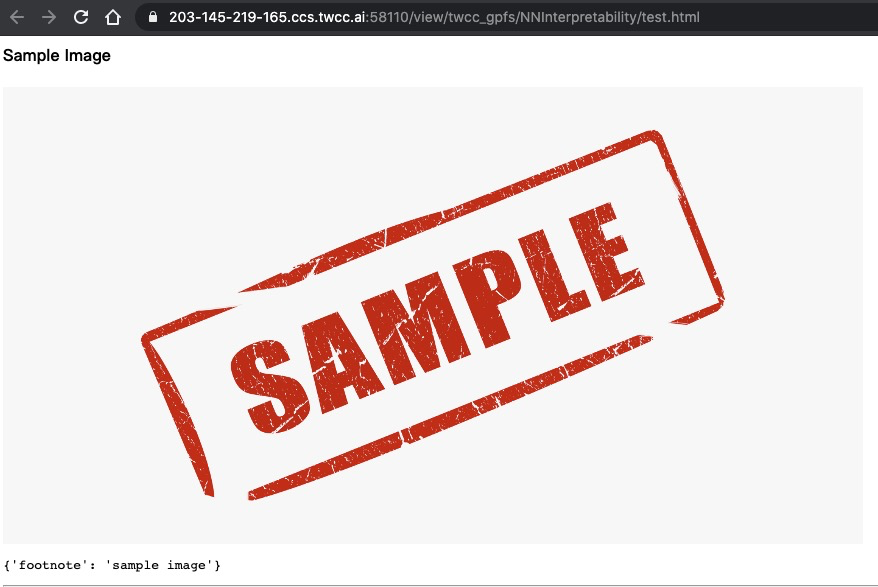

In [5]:
import logging

import cv2
import numpy as np
import vlogging

logger = logging.getLogger("demo")
fh = logging.FileHandler('test.html', mode="w")

logger.setLevel(logging.DEBUG)
logger.addHandler(fh)

image = cv2.imread('sample_image.png')
logger.info(vlogging.VisualRecord('Sample Image', image, {'footnote': 'sample image'}, fmt='png'))


### Load a pretreained model and show the CAM

The code below shows how to obtain the outputs of the activation_1 layer from a Resnet50 model.


In [6]:
import numpy as np
import tensorflow as tf

layers_name = ['activation_1']
IMAGE_PATH = './cat.jpg'

# Model to examine
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

# Image to pass as input
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

In [7]:
print(activations_1)

[]


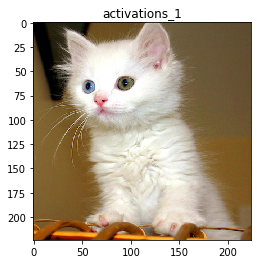

In [8]:
# Testing
from matplotlib import pyplot as plt

IMAGE_PATH = './cat.jpg'
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
# img = tf.keras.preprocessing.image.img_to_array(img)

plt.imshow(img)
plt.title('activations_1')
plt.show()

TypeError: Invalid shape (0,) for image data

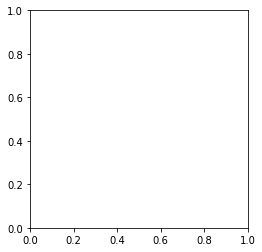

In [9]:
from matplotlib import pyplot as plt
plt.imshow(activations_1)
plt.title('activations_1')
plt.show()

### Display images in separate, interactive tabs for each class

In [10]:
#Show it now
import ipyplot


img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# ipyplot.plot_images([img_org, img_cam], max_images=20, img_width=150)
ipyplot.plot_class_tab([img_org, img_cam], max_images=20, img_width=150)

AttributeError: module 'ipyplot' has no attribute 'plot_class_tab'

### Grad CAM with raw Implementation

https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54

** All these Grad CAM methods was coded in the tf-explain. **


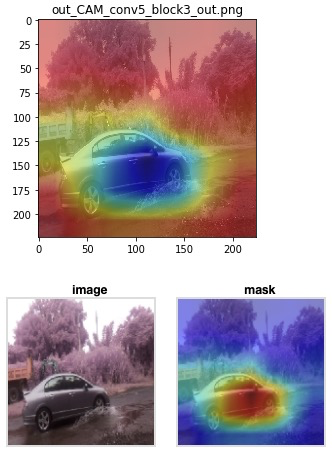

* the mask color (heat map) may reverseed cause the cv2 is BGR formate.

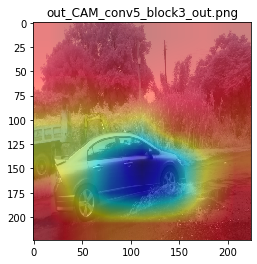


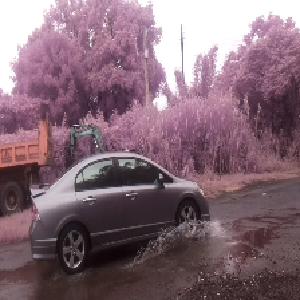
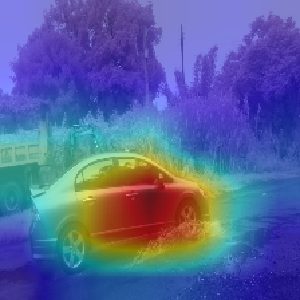

In [11]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = './0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out

""" imagenet1000_clsidx_to_labels.txt

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

281: 'tabby, tabby cat',
479: 'car wheel',

"""
CAT_CLASS_INDEX = 479 #281

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 0.5, 0)


#Save CAM image
out_name = 'out_CAM_' + LAYER_NAME + '.png'
cv2.imwrite(out_name, output_image) # OK with RGB format

#Show it now
plt.imshow(output_image)
plt.title(out_name)
plt.show()

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

ipyplot.plot_images([img_org, img_cam],['image', 'mask'], max_images=20, img_width=150)

### List layer name for used

In [55]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_36[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
!unrar

/bin/bash: unrar: command not found


In [ ]:
# https://github.com/sicara/tf-explain/issues/151
# TypeError: 'NoneType' object is not callable

In [24]:
  
import tensorflow as tf

from tf_explain.core.grad_cam import GradCAM

IMAGE_PATH = "./cat.jpg"

if __name__ == "__main__":
    model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)

    #model.summary()
    data = ([img], None)

    tabby_cat_class_index = 281
    explainer = GradCAM()
    # Compute GradCAM on VGG16
    grid = explainer.explain(
        data, model, class_index=tabby_cat_class_index, layer_name="block5_conv3"
    )
    explainer.save(grid, ".", "grad_cam.png")

In [25]:
!ls -la grad_cam.png

-rw-r--r-- 1 u3148947 TRI108216 83839 Aug 31 12:16 grad_cam.png
